### Group ID: GNN Group 01
### Group Members Name with Student ID:
|Name             |Bits ID   |        Contribution|
|-|-|-|
| Adarsh Sivanandan         |   2023AA05811   |   100% |
| Mano Ranjan Sahu          |   2023AA05738   |   100% |
| Mukesh Kumar Saini        |   2023aa05880   |   100% |
| Sanjay Kumar Agarwal      |   2023AA05611   |   100% |
| Vaibhav Bajpai            |   2023aa05631   |   100% |

Link of Python code in BITS library needs to be given as we will be running the code in Lab environment.
Python code file path in virtual lab: /home/labuser/Desktop/Persistent_Folder/Group_1/Annonymous_walk_node_prediction_Group_01.ipynb

# Primary Task: Create ML model based on Anonymous Walk Embeddings for node level prediction
## There are 5 major task that have been implemented and all the details for each task has been explained in detail before starting of each sub task below.
## Sub Task 1: Data Preprocessing & Feature Extraction

- the ogbg-molhiv dataset has been loaded.
- Node features (atomic properties) and edge features (bond types) have been extracted.
- Anonymous Walk Embeddings (AWE) for molecular graphs have also been generated

In [438]:
!pip install torch-geometric ogb rdkit-pypi

In [439]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__.split('+')[0])").html

Looking in links: https://data.pyg.org/whl/torch-2.5.1.html


In [440]:
# required packages
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import networkx as nx
from rdkit import Chem
from rdkit.Chem import Draw
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_networkx
from ogb.graphproppred import PygGraphPropPredDataset
from torch.utils.data import DataLoader, TensorDataset
from ogb.utils.features import atom_to_feature_vector, bond_to_feature_vector

import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import Adam
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from sklearn.metrics import roc_curve, auc
from torchsummary import summary

In [441]:
# printing to check the memory allocated/reserved
print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"Reserved Memory: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

Allocated Memory: 0.00 GB
Reserved Memory: 0.00 GB


In [442]:
# Move dataset to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

In [443]:
# Custom PyTorch dataset that integrates Anonymous Walk Embeddings (AWE) with molecular graphs.
# Each graph's node features are replaced with repeated AWE embeddings for consistency in GNN processing.
from torch_geometric.data import Data
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, awe_features):
        self.dataset = dataset  # PyG dataset
        self.awe_features = awe_features  # Precomputed AWE embeddings

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        graph = self.dataset[idx]
        awe_feat = self.awe_features[idx]

        # Expand AWE feature vector for all nodes
        num_nodes = graph.edge_index.max().item() + 1  # Get total nodes
        x = awe_feat.repeat(num_nodes, 1)  # Copy AWE feature for all nodes

        # Assign `x` to the graph
        graph.x = x

        return awe_feat, graph, graph.y

In [444]:
# Load dataset
dataset = PygGraphPropPredDataset(name="ogbg-molhiv")

/usr/local/lib/python3.11/dist-packages/ogb/graphproppred/dataset_pyg.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed

In [445]:
small_dataset = dataset[:2000]  # Use first 2000 graphs only
rint(f"Using Small Dataset with {len(small_dataset)} graphs")

Using Small Dataset with 2000 graphs


In [446]:
# Generates anonymous walks for a molecular graph.
# Converts a PyG graph to NetworkX, performs random walks,
# and encodes them as anonymous walk sequences.

def generate_anonymous_walks(graph, walk_length=5, num_walks=10):
    """Generates anonymous walks for a given molecular graph."""

    G = to_networkx(graph, to_undirected=True)  # Convert PyG to NetworkX
    walks = []

    for node in G.nodes():
        for _ in range(num_walks):
            walk = [node]
            while len(walk) < walk_length:
                neighbors = list(G.neighbors(walk[-1]))
                if not neighbors:
                    break
                next_node = np.random.choice(neighbors)
                walk.append(next_node)

            # Convert to anonymous walk
            anon_walk = []
            node_to_index = {}
            for step in walk:
                if step not in node_to_index:
                    node_to_index[step] = len(node_to_index)
                anon_walk.append(node_to_index[step])

            walks.append(tuple(anon_walk))

    return walks

In [447]:
#Extracts AWE features using anonymous walk frequencies.
#   Applies TF-IDF style normalization to improve representation.

def extract_AWE_features(graph, walk_length=10, num_walks=20):
    """Generates richer AWE features with increased walk coverage."""

    anon_walks = generate_anonymous_walks(graph, walk_length, num_walks)
    walk_counts = Counter(anon_walks)  # Count occurrences of each walk

    # Use TF-IDF Encoding instead of simple frequency
    awe_embedding = np.zeros(len(walk_counts))
    total_walks = sum(walk_counts.values())

    for i, walk in enumerate(walk_counts.keys()):
        awe_embedding[i] = walk_counts[walk] / total_walks  # Normalize

    return awe_embedding

In [448]:
# Define fixed embedding length
MAX_AWE_LENGTH = 10  # Adjust based on dataset statistics

def pad_or_truncate(vector, max_length=MAX_AWE_LENGTH):
    """Ensures all AWE feature vectors have the same length."""
    if len(vector) > max_length:
        return vector[:max_length]  # Truncate
    elif len(vector) < max_length:
        return np.pad(vector, (0, max_length - len(vector)))  # Pad with zeros
    return vector

In [449]:
# Efficiently extracts AWE features in batches.
# Also collects per-graph edge indices for later processing.

def extract_AWE_features_batch(dataset, batch_size=512):
    """Extract AWE features and per-graph edge indices efficiently."""
    awe_features_list = []
    labels_list = []
    edge_index_list = []  # Store list of edge_index per graph

    for i in range(0, len(dataset), batch_size):
        batch_data = dataset[i : i + batch_size]

        batch_awe_features = []
        batch_labels = []
        batch_edge_indices = []  # Temporary list for this batch

        for data in batch_data:
            awe_features = extract_AWE_features(data)
            awe_features = pad_or_truncate(awe_features)

            batch_awe_features.append(awe_features)
            batch_labels.append(data.y.item())
            batch_edge_indices.append(data.edge_index)  # Store edge_index per graph

        # Convert batch to PyTorch tensors
        batch_awe_features = torch.tensor(np.array(batch_awe_features), dtype=torch.float32).to(device)
        batch_labels = torch.tensor(batch_labels, dtype=torch.long).to(device)

        # Append batch results
        awe_features_list.append(batch_awe_features)
        labels_list.append(batch_labels)
        edge_index_list.extend(batch_edge_indices)  # Extend list instead of concatenation

    # Concatenate AWE features and labels
    X = torch.cat(awe_features_list, dim=0)
    y = torch.cat(labels_list, dim=0)

    return X, y, edge_index_list  # Keep edge_index as a **list of tensors**

In [450]:
# Extract AWE features (now includes per-graph edge_index)
X, y, edge_index_list = extract_AWE_features_batch(small_dataset)
print(f"Dataset Choosen from the Master GraphSet: {X.shape}, y: {y.shape}, edge_index_list: {len(edge_index_list)}")

Dataset Choosen from the Master GraphSet: torch.Size([2000, 10]), y: torch.Size([2000]), edge_index_list: 2000


In [451]:
#Custom collate function for batching molecular graphs.
#Ensures node features exist and applies proper batch handling.

from torch_geometric.data import Batch

def collate_fn(batch):
    awe_feats, graphs, labels = zip(*batch)  # Unpack batch

    #for i, graph in enumerate(graphs):
        #print(f"🔍 Graph {i} - x Shape: {graph.x.shape if graph.x is not None else 'None'}")

    for i, graph in enumerate(graphs):
        if graph.x is None:  # Ensure node features exist
            num_nodes = graph.num_nodes
            graph.x = awe_feats[i].repeat(num_nodes, 1)  # Copy AWE features per node

    batch_graph = Batch.from_data_list(graphs)  # Correct batching
    return torch.stack(awe_feats), batch_graph, torch.tensor(labels)

In [452]:
# Pass correct edge_index list to GraphDataset
graph_dataset = GraphDataset(small_dataset, X)

# Convert to DataLoader for batch processing
batch_size = 8
train_loader = DataLoader(graph_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(graph_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [453]:
print(f"Dataset Shape X: {X.shape}, y: {y.shape}, Edge Index Samples: {len(edge_index_list)}")

Dataset Shape X: torch.Size([2000, 10]), y: torch.Size([2000]), Edge Index Samples: 2000


In [454]:
print(dataset.meta_info)

num tasks                                                                1
eval metric                                                         rocauc
download_name                                                          hiv
version                                                                  1
url                      http://snap.stanford.edu/ogb/data/graphproppre...
add_inverse_edge                                                      True
data type                                                              mol
has_node_attr                                                         True
has_edge_attr                                                         True
task type                                            binary classification
num classes                                                              2
split                                                             scaffold
additional node files                                                 None
additional edge files    

## Sub Task 2: Graph Construction & Representation

- Molecular graphs into PyG Data objects have been converted.
- The node/edge features and AWE embeddings have been stored in a structured format.
- A custom dataset class & data loader for efficient batching has been implemented

In [455]:
# Function to extract features from SMILES
def extract_features(data_index, smiles_dict):
    """Extracts node (atom) and edge (bond) features from a molecule graph."""

    # Retrieve SMILES using the dataset index
    smiles_string = smiles_dict.get(data_index, None)

    if smiles_string is None:
        raise ValueError(f"SMILES not found for molecule index: {data_index}")

    mol = Chem.MolFromSmiles(smiles_string)

    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles_string}")

    # Extract atom features
    atom_features = np.array([atom_to_feature_vector(atom) for atom in mol.GetAtoms()])

    # Extract bond features
    bond_features = []
    if len(mol.GetBonds()) > 0:
        for bond in mol.GetBonds():
            bond_features.append(bond_to_feature_vector(bond))

    return atom_features, np.array(bond_features)

In [456]:
# Visualizes a molecular graph from the dataset.
# Converts PyG graph to NetworkX and plots the structure.

def visualize_molecule_graph(data_sample, title="Molecule Graph"):
    """Visualizes a molecule graph using NetworkX."""

    # Convert PyG Data object to NetworkX graph
    G = to_networkx(data_sample, to_undirected=True)

    # Draw the graph
    plt.figure(figsize=(5, 5))
    nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=500)
    plt.title(title)
    plt.show()

In [457]:
# Load the CSV file
csv_path = "./dataset/ogbg_molhiv/mapping/mol.csv.gz"
df = pd.read_csv(csv_path)

# Create a mapping from dataset index → SMILES
smiles_dict = dict(zip(df.index, df["smiles"]))

Atom Features Shape: (19, 9)
Bond Features Shape: (20, 3)


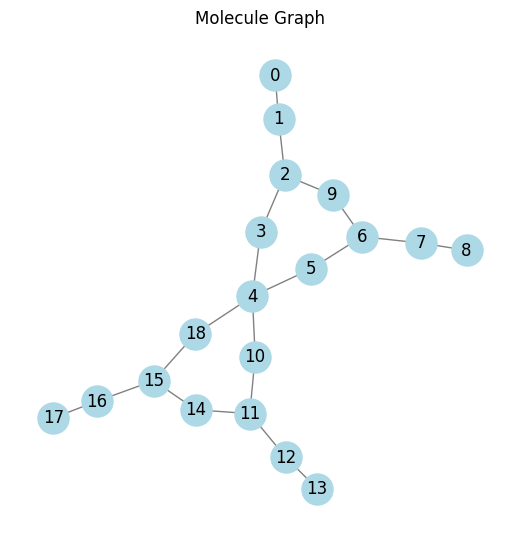

In [458]:
# Extract and visualize one sample
data_index = 0  # First molecule graph
atom_feat, bond_feat = extract_features(data_index, smiles_dict)
print("Atom Features Shape:", atom_feat.shape)
print("Bond Features Shape:", bond_feat.shape)
#visualize_molecule(data_sample)

# Example: Visualize first molecule as a graph
data_sample = dataset[0]  # First molecule graph
visualize_molecule_graph(data_sample)

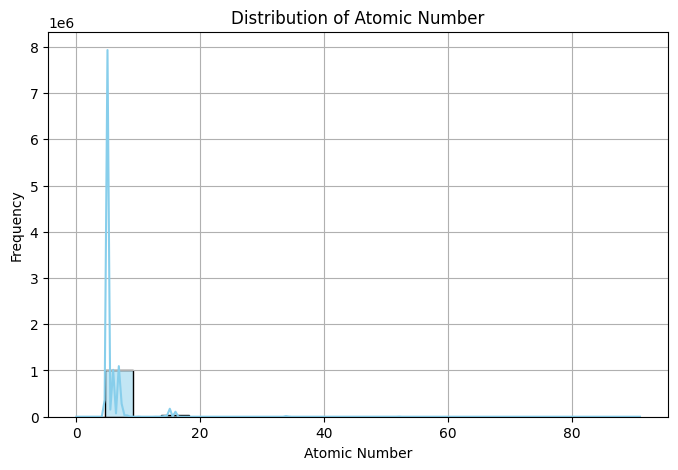

In [459]:
# Plots the distribution of a selected atomic feature.
# Extracts feature values from dataset and visualizes using a histogram.

def plot_atomic_feature_distribution(dataset, feature_index=0, feature_name="Atomic Number"):
    feature_values = []

    for data in dataset:
        atom_features = data.x[:, feature_index].cpu().numpy()  # Extract the selected feature
        feature_values.extend(atom_features)

    # Plot the histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(feature_values, bins=20, kde=True, color="skyblue")
    plt.xlabel(feature_name)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {feature_name}")
    plt.grid(True)
    plt.show()

# Example: Plot histogram for atomic number (feature index 0)
plot_atomic_feature_distribution(dataset, feature_index=0, feature_name="Atomic Number")

# Providing some of the statistic we used during our Graph Analysis

In [460]:
print("AWE Feature Tensor Stats:")
print("Min:", X.min().item(), "Max:", X.max().item(), "Mean:", X.mean().item())
print("Labels Distribution:", torch.bincount(y))

AWE Feature Tensor Stats:
Min: 0.0 Max: 1.0 Mean: 0.005653634667396545
Labels Distribution: tensor([1918,   82])


In [461]:
print("Unique Labels in Dataset:", torch.unique(y))
print("Min Label:", y.min().item(), "Max Label:", y.max().item())
print("Label Shape:", y.shape)
print("First 10 Labels:", y[:10])

Unique Labels in Dataset: tensor([0, 1])
Min Label: 0 Max Label: 1
Label Shape: torch.Size([2000])
First 10 Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [462]:
print("Dataset X Shape:", X.shape)
print("Min Feature Value:", X.min().item(), "Max Feature Value:", X.max().item())
print("First AWE Feature Vector:", X[0])

Dataset X Shape: torch.Size([2000, 10])
Min Feature Value: 0.0 Max Feature Value: 1.0
First AWE Feature Vector: tensor([0.0026, 0.0053, 0.0079, 0.0053, 0.0079, 0.0079, 0.0079, 0.0026, 0.0026,
        0.0342])


In [463]:
print("Total Graphs:", len(edge_index_list))
print("Graph 0 → Edge Index Shape:", edge_index_list[0].shape)
print("Graph 1 → Edge Index Shape:", edge_index_list[1].shape)
print("Graph 2 → Edge Index Shape:", edge_index_list[2].shape)

Total Graphs: 2000
Graph 0 → Edge Index Shape: torch.Size([2, 40])
Graph 1 → Edge Index Shape: torch.Size([2, 88])
Graph 2 → Edge Index Shape: torch.Size([2, 48])


In [464]:
# Check DataLoader
batch = next(iter(train_loader))

print("Batch AWE Feature Type:", type(batch[0]))  # Should be a tensor
print("Batch Edge Index Type:", type(batch[1]))  # Check if it's a list
print("Batch Labels Type:", type(batch[2]))  # Should be a tensor

# Print shapes if they are tensors
if isinstance(batch[0], torch.Tensor):
    print("Batch AWE Feature Shape:", batch[0].shape)

if isinstance(batch[1], torch.Tensor):
    print("Batch Edge Index Shape:", batch[1].shape)
elif isinstance(batch[1], list):
    print("Batch Edge Index is a list with", len(batch[1]), "graphs.")

if isinstance(batch[2], torch.Tensor):
    print("Batch Labels Shape:", batch[2].shape)

Batch AWE Feature Type: <class 'torch.Tensor'>
Batch Edge Index Type: <class 'abc.DataBatch'>
Batch Labels Type: <class 'torch.Tensor'>
Batch AWE Feature Shape: torch.Size([8, 10])
Batch Labels Shape: torch.Size([8])


In [465]:
print("Checking CUDA Memory Usage...")
print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"Reserved Memory: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated() / 1e9:.2f} GB")

Checking CUDA Memory Usage...
Allocated Memory: 0.00 GB
Reserved Memory: 0.00 GB
Max Memory Allocated: 0.00 GB


In [466]:
y_cpu = y.cpu().numpy()
print("Unique Labels in Dataset:", np.unique(y_cpu))
print("Min Label:", y_cpu.min(), "| Max Label:", y_cpu.max())
print("Label Distribution:", Counter(y_cpu))

Unique Labels in Dataset: [0 1]
Min Label: 0 | Max Label: 1
Label Distribution: Counter({0: 1918, 1: 82})


In [467]:
print("Dataset X Shape:", X.shape)
print("Min Feature Value:", X.min().item(), "| Max Feature Value:", X.max().item())
print("First AWE Feature Vector:", X[0])

Dataset X Shape: torch.Size([2000, 10])
Min Feature Value: 0.0 | Max Feature Value: 1.0
First AWE Feature Vector: tensor([0.0026, 0.0053, 0.0079, 0.0053, 0.0079, 0.0079, 0.0079, 0.0026, 0.0026,
        0.0342])


In [468]:
print(f"Total Graphs: {len(edge_index_list)}")
for i in range(3):  # Print first 3 graphs
    print(f"Graph {i} → Edge Index Shape: {edge_index_list[i].shape}")

Total Graphs: 2000
Graph 0 → Edge Index Shape: torch.Size([2, 40])
Graph 1 → Edge Index Shape: torch.Size([2, 88])
Graph 2 → Edge Index Shape: torch.Size([2, 48])


In [469]:
batch = next(iter(train_loader))

print(f"Batch AWE Feature Type: {type(batch[0])}")
print(f"Batch Edge Index Type: {type(batch[1])}")
print(f"Batch Labels Type: {type(batch[2])}")

print(f"Batch AWE Feature Shape: {batch[0].shape}")  # Expect [batch_size, 10]
print(f"Batch Edge Index is a list with {len(batch[1])} graphs.")  # Expect batch_size
print(f"Batch Labels Shape: {batch[2].shape}")  # Expect [batch_size]

Batch AWE Feature Type: <class 'torch.Tensor'>
Batch Edge Index Type: <class 'abc.DataBatch'>
Batch Labels Type: <class 'torch.Tensor'>
Batch AWE Feature Shape: torch.Size([8, 10])
Batch Edge Index is a list with 8 graphs.
Batch Labels Shape: torch.Size([8])


In [470]:
print("Checking CUDA Memory Usage Before Training...")
print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"Reserved Memory: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated() / 1e9:.2f} GB")

Checking CUDA Memory Usage Before Training...
Allocated Memory: 0.00 GB
Reserved Memory: 0.00 GB
Max Memory Allocated: 0.00 GB


In [471]:
torch.cuda.empty_cache()  # Free up any unused GPU memory

print("Checking CUDA Memory Usage Before Training...")
print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"Reserved Memory: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated() / 1e9:.2f} GB")

Checking CUDA Memory Usage Before Training...
Allocated Memory: 0.00 GB
Reserved Memory: 0.00 GB
Max Memory Allocated: 0.00 GB


In [472]:
print(f"Dataset Size: {len(dataset)}")
print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")
print(f"Sample Edge Index Shape: {edge_index_list[0].shape}")

Dataset Size: 41127
X Shape: torch.Size([2000, 10])
y Shape: torch.Size([2000])
Sample Edge Index Shape: torch.Size([2, 40])


In [473]:
batch = next(iter(train_loader))

print(f"Batch AWE Feature Shape: {batch[0].shape}")  # Expect [batch_size, 10]
print(f"Batch Edge Index Type: {type(batch[1])}")  # Expect list of tensors
print(f"Batch Labels Shape: {batch[2].shape}")  # Expect [batch_size]

Batch AWE Feature Shape: torch.Size([8, 10])
Batch Edge Index Type: <class 'abc.DataBatch'>
Batch Labels Shape: torch.Size([8])


In [474]:
print("Unique Labels:", torch.unique(y))
print("Min Label:", y.min().item(), "| Max Label:", y.max().item())

Unique Labels: tensor([0, 1])
Min Label: 0 | Max Label: 1


In [475]:
first_item = train_loader.dataset[0]  # Get first item
print("Type of First Item:", type(first_item))
print("Contents of First Item:", first_item)

Type of First Item: <class 'tuple'>
Contents of First Item: (tensor([0.0026, 0.0053, 0.0079, 0.0053, 0.0079, 0.0079, 0.0079, 0.0026, 0.0026,
        0.0342]), Data(edge_index=[2, 40], edge_attr=[40, 3], x=[19, 10], y=[1, 1], num_nodes=19), tensor([[0]]))


In [476]:
batch = next(iter(train_loader))

X_batch, batch_graph, y_batch = batch  # Unpack batch

print(f"Batch AWE Feature Shape: {X_batch.shape}")  # Expected: [batch_size, 10]
print(f"Batch Graph Type: {type(batch_graph)}")  # Expected: PyG Batch
print(f"Batch Graph Edge Index Shape: {batch_graph.edge_index.shape}")
print(f"Batch Labels Shape: {y_batch.shape}")  # Expected: [batch_size, 1]

Batch AWE Feature Shape: torch.Size([8, 10])
Batch Graph Type: <class 'abc.DataBatch'>
Batch Graph Edge Index Shape: torch.Size([2, 414])
Batch Labels Shape: torch.Size([8])


In [477]:
for i, graph in enumerate(dataset[:10]):  # Print first 10 graphs
    print(f"Graph {i}: num_nodes = {graph.num_nodes}, edges = {graph.edge_index.shape[1]}")

Graph 0: num_nodes = 19, edges = 40
Graph 1: num_nodes = 39, edges = 88
Graph 2: num_nodes = 21, edges = 48
Graph 3: num_nodes = 24, edges = 50
Graph 4: num_nodes = 10, edges = 18
Graph 5: num_nodes = 16, edges = 32
Graph 6: num_nodes = 10, edges = 20
Graph 7: num_nodes = 18, edges = 38
Graph 8: num_nodes = 26, edges = 54
Graph 9: num_nodes = 20, edges = 42


## Sub Task 3: Model Design & Implementation

- Both MLP-based classifier and AWE+GNN model class have been implemented.


# MLP Model Creation and Evaluation

In [478]:
# Evaluate Function
def evaluate_MLP(model, test_loader):
    """Evaluate the model and compute ROC-AUC."""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for awe_feats, _, y_batch in test_loader:  # Only awe_feats are passed
            awe_feats, y_batch = awe_feats.to(device), y_batch.to(device)
            outputs = model(awe_feats)  # Forward pass with AWE features only
            all_preds.extend(outputs.cpu().numpy())  # Store predictions
            all_labels.extend(y_batch.cpu().numpy())  # Store true labels

    roc_auc = roc_auc_score(all_labels, all_preds)  # Compute ROC-AUC
    fpr, tpr, _ = roc_curve(all_labels, all_preds)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()
    return roc_auc

In [479]:
for data in train_loader:
    print(type(data))
    if isinstance(data, tuple):
        for item in data:
            print("f:", item.shape if hasattr(item, 'shape') else type(item))
    break  # Only need the first batch


<class 'tuple'>
f: torch.Size([8, 10])
f: <class 'abc.DataBatch'>
f: torch.Size([8])


In [480]:
# Define MLP-Based Model for AWE Features
class AWE_MLP(nn.Module):
    """MLP-based classifier for Anonymous Walk Embeddings (AWE)."""
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(AWE_MLP, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.fc3 = nn.Linear(out_dim, 1)  # Binary output
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.sigmoid(x).squeeze()

# Initialize Updated Model
model_MLP = AWE_MLP(in_dim=X.shape[1], hidden_dim=64, out_dim=32).to(device)

# Define Loss, Optimizer, and DataLoader
optimizer_MLP = torch.optim.Adam(model_MLP.parameters(), lr=0.001, weight_decay=1e-4)
criterion_MLP = nn.BCELoss()  # Binary Cross-Entropy Loss

# Summarizing MLP Model Parameters

In [481]:
#Verify Loss Function
print(f"Optimizer: {optimizer_MLP}")
print(f"Loss Function: {criterion_MLP}")

# Print Model Summary
print(model_MLP)

summary(model_MLP, (X.shape[1],))

sample_input = torch.randn(1, X.shape[1]).to(device)
sample_output = model_MLP(sample_input)
print(f"Sample Input Shape: {sample_input.shape} -> Sample Output Shape: {sample_output.shape}")

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Loss Function: BCELoss()
AWE_MLP(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             704
           Dropout-2                   [-1, 64]               0
            Linear-3                   [-1, 32]           2,080
            Linear-4                    [-1, 1]              33
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
----------------------------------------------------

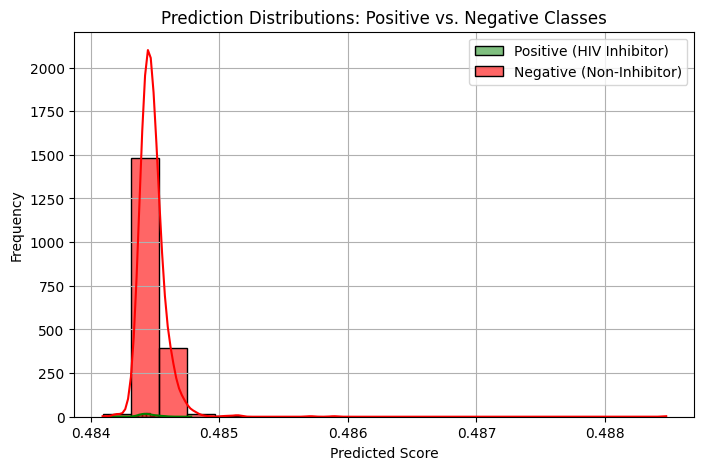

In [482]:
def plot_prediction_distribution(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for awe_feats, _, y_batch in test_loader:
            awe_feats, y_batch = awe_feats.to(device), y_batch.to(device)
            outputs = model(awe_feats).cpu().numpy()
            all_preds.extend(outputs)
            all_labels.extend(y_batch.cpu().numpy())

    # Convert to NumPy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Separate positive and negative class predictions
    pos_preds = all_preds[all_labels == 1]
    neg_preds = all_preds[all_labels == 0]

    # Plot the distributions
    plt.figure(figsize=(8, 5))
    sns.histplot(pos_preds, bins=20, kde=True, color="green", label="Positive (HIV Inhibitor)")
    sns.histplot(neg_preds, bins=20, kde=True, color="red", label="Negative (Non-Inhibitor)", alpha=0.6)

    plt.xlabel("Predicted Score")
    plt.ylabel("Frequency")
    plt.title("Prediction Distributions: Positive vs. Negative Classes")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: Plot prediction distribution for MLP model
plot_prediction_distribution(model_MLP, test_loader)

## Sub Task 4: Training & Optimization

- Adam optimizer with weight decay and learngin rate has been used
- Binary Cross-Entropy Loss has been used as loss function

In [483]:
# Train Function
def train_MLP(model, train_loader, optimizer, criterion, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for awe_feats, _, y_batch in train_loader:  # Only awe_feats are passed to model
            awe_feats, y_batch = awe_feats.to(device), y_batch.to(device)

            optimizer.zero_grad()  # Clear gradients
            outputs = model_MLP(awe_feats)  # Forward pass with AWE features only
            loss = criterion(outputs, y_batch.float())  # Binary Cross-Entropy Loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Optimizer step

            total_loss += loss.item()  # Accumulate loss for logging

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

In [484]:
# Train Model
print("Training Started...")
train_MLP(model_MLP, train_loader, optimizer_MLP, criterion_MLP)

Training Started...
Epoch 1/20, Loss: 68.0871
Epoch 2/20, Loss: 43.1984
Epoch 3/20, Loss: 42.9571
Epoch 4/20, Loss: 43.1438
Epoch 5/20, Loss: 43.7579
Epoch 6/20, Loss: 43.1717
Epoch 7/20, Loss: 43.3786
Epoch 8/20, Loss: 43.3644
Epoch 9/20, Loss: 43.2459
Epoch 10/20, Loss: 43.4779
Epoch 11/20, Loss: 43.5155
Epoch 12/20, Loss: 43.1482
Epoch 13/20, Loss: 43.4676
Epoch 14/20, Loss: 43.8066
Epoch 15/20, Loss: 43.2382
Epoch 16/20, Loss: 42.8986
Epoch 17/20, Loss: 43.2804
Epoch 18/20, Loss: 43.5659
Epoch 19/20, Loss: 43.1878
Epoch 20/20, Loss: 43.6505


## Sub Task 5: Evaluation & Visualization

- Evaluation using ROC-AUC score have beed used for both models
- Molecular Graph, Feature distribution and Training Loss and ROC Curve have been plotted for better understanding

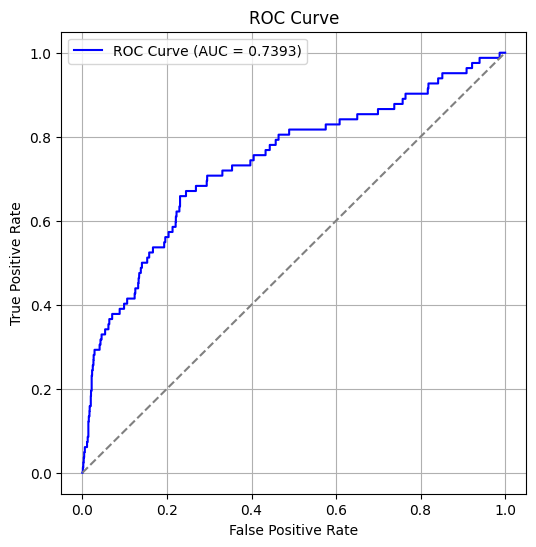

Final ROC-AUC Score: 0.7393


In [485]:
# Evaluate Model
roc_auc = evaluate_MLP(model_MLP, test_loader)
print(f"Final ROC-AUC Score: {roc_auc:.4f}")

# AWE + GMM Model Creation and Evaluation

In [486]:
# Define AWE_GNN Model
class AWE_GNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(AWE_GNN, self).__init__()
        self.gcn1 = GCNConv(in_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, out_dim)

        #print(f"out_dim: {out_dim}, in_dim: {in_dim}")
        #print("out_dim + in_dim:", out_dim + in_dim)

        self.fc = nn.Linear(out_dim + in_dim, 1)  # Combine GNN + AWE features

    def forward(self, x, edge_index, awe_feat, batch):
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))

        # Global pooling (mean over nodes)
        x = global_mean_pool(x, batch)

        # Concatenate AWE features
        awe_feat_expanded = awe_feat.repeat_interleave(x.shape[0] // awe_feat.shape[0], dim=0)

        ##print("x shape:", x.shape)  # Expected: [num_nodes, hidden_dim]
        #print("awe_feat shape:", awe_feat.shape)  # Expected: [batch_size, feature_dim]
        #print("awe_feat_expanded shape:", awe_feat_expanded.shape)  # Expected: [num_nodes, feature_dim]

        # Concatenate
        combined = torch.cat([x, awe_feat_expanded], dim=-1)
        #print("Final combined shape before FC:", combined.shape)
        return torch.sigmoid(self.fc(combined)).squeeze()

In [487]:
# Initialize Model (Ensure correct in_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_dim = X.shape[1]  # Ensure input matches dataset dimensions
model_GNN = AWE_GNN(in_dim=in_dim, hidden_dim=64, out_dim=32).to(device)

# Define Loss and Optimizer
optimizer_GNN = torch.optim.Adam(model_GNN.parameters(), lr=0.001, weight_decay=1e-4)
criterion_GNN = nn.BCELoss()

# AWE + GNN Model details

In [488]:
#Verify Loss Function
print(f"Optimizer: {optimizer_GNN}")
print(f"Loss Function: {criterion_GNN}")

# Print Model Summary
print(model_GNN)

total_params = sum(p.numel() for p in model_GNN.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params}")

for name, param in model_GNN.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Trainable: {param.requires_grad}")

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Loss Function: BCELoss()
AWE_GNN(
  (gcn1): GCNConv(10, 64)
  (gcn2): GCNConv(64, 32)
  (fc): Linear(in_features=42, out_features=1, bias=True)
)
Total Trainable Parameters: 2827
Layer: gcn1.bias | Size: torch.Size([64]) | Trainable: True
Layer: gcn1.lin.weight | Size: torch.Size([64, 10]) | Trainable: True
Layer: gcn2.bias | Size: torch.Size([32]) | Trainable: True
Layer: gcn2.lin.weight | Size: torch.Size([32, 64]) | Trainable: True
Layer: fc.weight | Size: torch.Size([1, 42]) | Trainable: True
Layer: fc.bias | Size: torch.Size([1]) | Trainable: True


In [489]:
# Define Training Function
def train_GNN(model, train_loader, optimizer, criterion, num_epochs=20):
    model.train()
    losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        for awe_feats, graph, y_batch in train_loader:
            awe_feats, y_batch = awe_feats.to(device), y_batch.to(device)
            graph = graph.to(device)

            optimizer.zero_grad()
            outputs = model_GNN(graph.x, graph.edge_index, awe_feats, graph.batch)
            loss = criterion(outputs, y_batch.float())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

    # Plot Loss Curve
    plt.figure()
    plt.plot(range(1, num_epochs + 1), losses, marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.show()

In [490]:
# Define Evaluation Function
def evaluate_GNN(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for awe_feats, graph, y_batch in test_loader:
            awe_feats, y_batch = awe_feats.to(device), y_batch.to(device)
            graph = graph.to(device)

            outputs = model_GNN(graph.x, graph.edge_index, awe_feats, graph.batch)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    roc_auc = roc_auc_score(all_labels, all_preds)

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    return roc_auc


Training AWE + GNN Model...
Epoch 1/20, Loss: 79.4417
Epoch 2/20, Loss: 42.6855
Epoch 3/20, Loss: 42.5829
Epoch 4/20, Loss: 42.5901
Epoch 5/20, Loss: 42.5098
Epoch 6/20, Loss: 42.4231
Epoch 7/20, Loss: 42.5268
Epoch 8/20, Loss: 42.4736
Epoch 9/20, Loss: 42.4594
Epoch 10/20, Loss: 42.4605
Epoch 11/20, Loss: 42.4949
Epoch 12/20, Loss: 42.4426
Epoch 13/20, Loss: 42.5414
Epoch 14/20, Loss: 42.3977
Epoch 15/20, Loss: 42.2075
Epoch 16/20, Loss: 42.2800
Epoch 17/20, Loss: 42.5590
Epoch 18/20, Loss: 42.2777
Epoch 19/20, Loss: 42.4413
Epoch 20/20, Loss: 42.3413


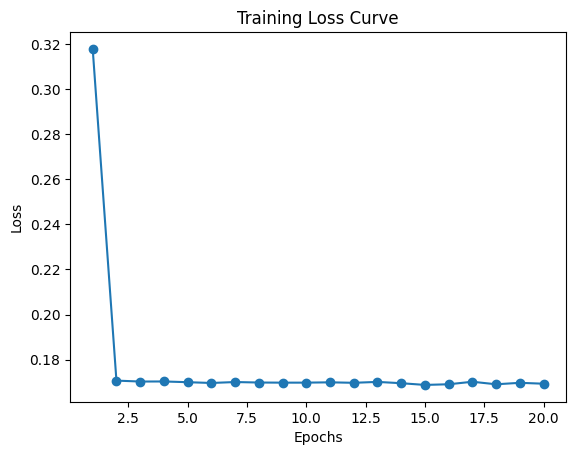

In [491]:
# Train AWE + GNN Model
print("Training AWE + GNN Model...")
train_GNN(model_GNN, train_loader, optimizer_GNN, criterion_GNN)


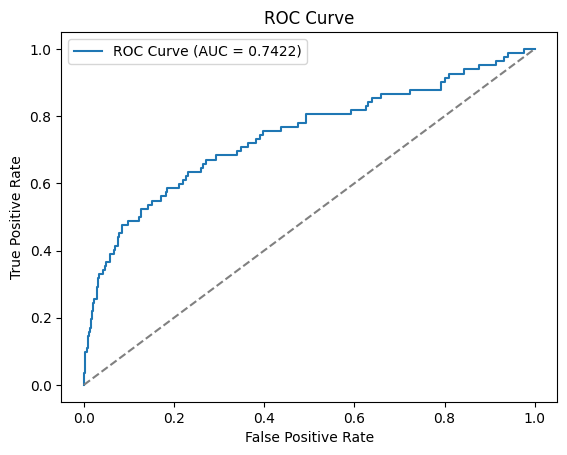

Final ROC-AUC Score: 0.7422


In [492]:
# Evaluate Model
roc_auc = evaluate_GNN(model_GNN, test_loader)
print(f"Final ROC-AUC Score: {roc_auc:.4f}")